# Model Tuning (Hyperparameter Optimization)
- 학습을 수행하기 전에 설정해야 하는 값인 hyperparameter의 최적값을 탐색

# Manual Search
- 최적의 하이퍼파라미터 값을 직접 탐색하는 방법
- 연구자가 다양한 하이퍼파라미터 조합을 실험하여 어떤 조합이 성능 향상에 좋을지 살펴보고 비교






- 구글 드라이브 연결

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

- 데이터 경로 변수

In [2]:
#DATA_PATH = "/content/drive/MyDrive/data/"
import os

DATA_PATH=os.getcwd()+'/data'

- 시드값

In [3]:
SEED = 42

- 데이터 불러오기

In [4]:
import pandas as pd
import numpy as np

train = pd.read_csv(f"{DATA_PATH}//titanic_train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}//titanic_test.csv") # 테스트 데이터
train.shape , test.shape

((916, 12), (393, 11))

In [5]:
train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
1,462,0,3,"Morley, Mr. William",male,34.0,0,0,364506,8.0500,NaN,S
2,1286,0,3,"Kink-Heilmann, Mr. Anton",male,29.0,3,1,315153,22.0250,NaN,S
3,1130,1,2,"Hiltunen, Miss. Marta",female,18.0,1,1,250650,13.0000,NaN,S
4,461,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,E12,S


- 결측치 확인하기

In [6]:
train.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
gender           0
age            180
sibsp            0
parch            0
ticket           0
fare             0
cabin          706
embarked         0
dtype: int64

In [7]:
test.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             1
cabin          308
embarked         2
dtype: int64

- 학습 데이터에서 얻은 통계량을 이용하여 결측치를 채워야한다.

In [8]:
age_mean = train["age"].mean()
fare_median = train["fare"].median()
cabin_unk = "UNK"
embarked_mode = train["embarked"].mode()[0]
age_mean , fare_median ,cabin_unk , embarked_mode

(29.904891304347824, 14.5, 'UNK', 'S')

- 학습데이터 결측치 처리

In [9]:
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)

- 테스트데이터 결측치 처리

In [10]:
test["age"] = test["age"].fillna(age_mean)
test["fare"] = test["fare"].fillna(fare_median)
test["cabin"] = test["cabin"].fillna(cabin_unk)
test["embarked"] = test["embarked"].fillna(embarked_mode)

In [11]:
train.isnull().sum().sum() , test.isnull().sum().sum()

(0, 0)

- 특성으로 사용할 변수 추가하기

In [12]:
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()
test_ft = test[cols].copy()
train_ft.shape, test_ft.shape

((916, 7), (393, 7))

- 범주형 변수 원핫인코딩하여 특성으로 추가하기

In [13]:
from sklearn.preprocessing import OneHotEncoder
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train[cols])

OneHotEncoder(handle_unknown='ignore')

In [14]:
# 학습 데이터
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1)
train_ft.head()

,age,sibsp,parch,fare,pclass,gender,embarked,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,71.0,0,0,49.5042,1,male,C,0.0,1.0,1.0,0.0,0.0
1,34.0,0,0,8.0500,3,male,S,0.0,1.0,0.0,0.0,1.0
2,29.0,3,1,22.0250,3,male,S,0.0,1.0,0.0,0.0,1.0
3,18.0,1,1,13.0000,2,female,S,1.0,0.0,0.0,0.0,1.0
4,48.0,0,0,26.5500,1,male,S,0.0,1.0,0.0,0.0,1.0


In [15]:
# 테스트 데이터
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1)
test_ft.head()

,age,sibsp,parch,fare,pclass,gender,embarked,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,62.000000,0,0,26.5500,1,male,S,0.0,1.0,0.0,0.0,1.0
1,28.000000,0,0,47.1000,1,male,S,0.0,1.0,0.0,0.0,1.0
2,24.000000,0,0,9.5000,3,male,S,0.0,1.0,0.0,0.0,1.0
3,29.904891,0,0,7.7333,3,female,Q,1.0,0.0,0.0,1.0,0.0
4,18.500000,0,0,7.2833,3,female,Q,1.0,0.0,0.0,1.0,0.0


- 문자열 데이터 제거

In [16]:
train_ft = train_ft.drop(columns=cols)
test_ft = test_ft.drop(columns=cols)

- Min-Max Scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_ft)

MinMaxScaler()

In [18]:
train_ft[train_ft.columns] = scaler.transform(train_ft)
train_ft.head()

,age,sibsp,parch,fare,pclass,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,0.887260,0.000,0.000000,0.096626,0.0,0.0,1.0,1.0,0.0,0.0
1,0.423776,0.000,0.000000,0.015713,1.0,0.0,1.0,0.0,0.0,1.0
2,0.361142,0.375,0.111111,0.042990,1.0,0.0,1.0,0.0,0.0,1.0
3,0.223350,0.125,0.111111,0.025374,0.5,1.0,0.0,0.0,0.0,1.0
4,0.599148,0.000,0.000000,0.051822,0.0,0.0,1.0,0.0,0.0,1.0


In [19]:
test_ft[test_ft.columns] = scaler.transform(test_ft)
test_ft.head()

,age,sibsp,parch,fare,pclass,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,0.774521,0.0,0.0,0.051822,0.0,0.0,1.0,0.0,0.0,1.0
1,0.348616,0.0,0.0,0.091933,0.0,0.0,1.0,0.0,0.0,1.0
2,0.298509,0.0,0.0,0.018543,1.0,0.0,1.0,0.0,0.0,1.0
3,0.372478,0.0,0.0,0.015094,1.0,1.0,0.0,0.0,1.0,0.0
4,0.229613,0.0,0.0,0.014216,1.0,1.0,0.0,0.0,1.0,0.0


- 정답 데이터

In [20]:
target = train["survived"]
target

0      0
1      0
2      0
3      1
4      1
      ..
911    1
912    0
913    0
914    0
915    0
Name: survived, Length: 916, dtype: int64

In [21]:
DATA_PATH

'c:\\study\\02_machine_learning/data'

In [22]:
np.save(DATA_PATH+'\\processed_train_data(titanic).npy',train_ft)
np.save(DATA_PATH+'\\processed_test_data(titanic).npy',test_ft)


# Grid Search
- 하이퍼파라미터 별로 다양한 값들을 지정하여 가능한 모든 조합에 대해 성능 결과를 측정한 후 가장 높은 성능을 발휘했던 하이퍼파라미터 조합을 최적값으로 선정하는 방법
- Manual Search에 비해 체계적인 방식이고, Manual Search와 비교하면 좀 더 균등하고 전역적인 탐색이 가능함
- 탐색하고자 하는 하이퍼파라미터의 개수를 여러 종류로 가져갈수록 가능한 모든 조합을 탐색하기 때문에 전체 탐색 시간이 기하급수적으로 증가한다는 단점이 있음

- GridSearchCV 클래스
    - estimator(첫번째 파라미터)
        - 모델 객체
    - param_grid(두번째 파라미터)
        - 탐색 구간을 딕셔너리로 전달
        - key는 하이퍼파라미터명
        - value는 탐색구간(iterable 객체)
    - scoring
        - 평가지표(문자열로 전달)
        - https://scikit-learn.org/stable/modules/model_evaluation.html
    - cv
        - cv 객체 또는 정수

In [23]:
from sklearn.model_selection import KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [24]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=SEED)
hp = {
    "n_estimators": range(100,121,10), # 트리수
    "criterion" : ["gini", "entropy"],
    "max_depth" : range(5,11,5),
    "min_samples_split" : range(2,5,2),
    "max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(
   model, # 모델 객체
   hp, # 하이퍼 파라미터 탐색 범위(딕셔너리 형태 그대로 전달할 것)
   cv = cv,
   scoring="roc_auc",
   n_jobs=-1
)
grid_search.fit(train_ft, target)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 11, 5),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': range(2, 5, 2),
                         'n_estimators': range(100, 121, 10)},
             scoring='roc_auc')

- 최적의 하이퍼 파라미터 조합의 교차검증 평균 점수

In [25]:
grid_search.best_score_

0.9144457173786703

- 최적의 하이퍼 파라미터 조합

In [26]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 100}

- 최적의 하이퍼파라미터 조합 적용하여 모델 객체 생성 후 학습 및 예측

In [27]:
model = RandomForestClassifier(random_state=SEED, **grid_search.best_params_)
model.fit(train_ft, target)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=4,
                       random_state=42)

In [28]:
pred = model.predict_proba(test_ft)[:,1]
pred[:5]

array([0.17601201, 0.19401594, 0.03364182, 0.92101312, 0.77181654])

- search 객체는 최적의 하이퍼파라미터 조합을 찾고 나서 해당 하이퍼 파라미터 조합으로 전체 학습데이터에 대하여 다시 fit 을 수행한다.
- 그래서 예측이 가능하다.

In [29]:
pred = grid_search.predict_proba(test_ft)[:,1]
pred[:5]

array([0.17601201, 0.19401594, 0.03364182, 0.92101312, 0.77181654])

# Random Search
- 하이퍼파라미터 별로 탐색 구간을 지정하여 가능한 모든 조합 중에 지정한 횟수만큼 하이퍼파라미터 조합을 랜덤 샘플링하여 성능 결과를 측정한 후 가장 높은 성능을 발휘했던 하이퍼파라미터 조합을 최적값으로 선정하는 방법
- RandomizedSearchCV
    - estimator(첫번째 파라미터)
        - 모델 객체
    - param_distributions(두번째 파라미터)
        - 탐색 구간을 딕셔너리로 전달
        - key는 하이퍼파라미터명
        - value는 탐색구간(iterable 객체)
    - n_iter
        - 탐색 횟수
    - scoring
        - 평가지표(문자열로 전달)
    - cv
        - cv 객체 또는 정수
    - random_state
        - 시드값

In [30]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestClassifier(random_state=SEED)
hp = {
    "n_estimators": range(100,201,2), # 트리수
    "criterion" : ["gini", "entropy"],
    "max_depth" : range(5,51,2),
    "min_samples_split" : range(2,21,1),
    "max_features": ["sqrt", "log2", None]
}

random_search = RandomizedSearchCV(
   model, # 모델 객체
   hp, # 하이퍼 파라미터 탐색 범위(딕셔너리 형태 그대로 전달할 것)
   cv = cv,
   scoring="roc_auc",
   n_jobs=-1,
   random_state = SEED,
   n_iter = 20
)
random_search.fit(train_ft, target)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(5, 51, 2),
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_split': range(2, 21),
                                        'n_estimators': range(100, 201, 2)},
                   random_state=42, scoring='roc_auc')

In [31]:
random_search.best_score_

0.9150661196469378

In [32]:
random_search.best_params_

{'n_estimators': 158,
 'min_samples_split': 14,
 'max_features': 'log2',
 'max_depth': 29,
 'criterion': 'entropy'}

# Grid Search vs Random Search
- random search 는 grid search 에 비해 불필요한 반복횟수를 줄이면서 그와 동시에 정해진 간격 사이에 위치한 하이퍼파라미터 조합에 대해서도 확률적으로 탐색이 가능하므로 더 많이 사용하는 편이다.
- random search 와 grid search 는 이전 까지의 하이퍼 파라미터 조합의 탐색 과정에서 얻어진 하이퍼파라미터 조합의 성능 결과에 대한 사전 지식이 전혀 반영 되어 있지 않기 때문에 비효율적인 요소가 있음.



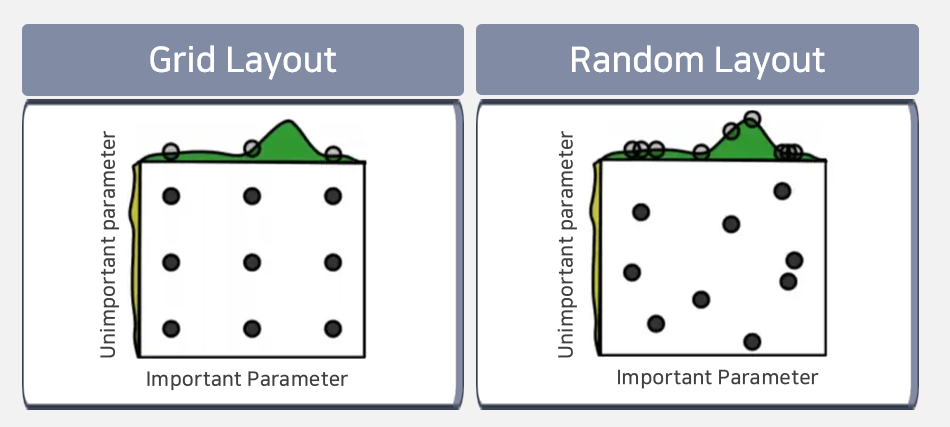